# SARIMA Method for Forecasting Product Sales
<style>
    .text {
        text-decoration: none
    }
</style>

## Table of Contens
1. [DATA LOADING AND OVERIEW](#data)
- [Import Necessary Librairies](#libra)
- [Loading Data](#load)
- [Display Data Frame](#display)
2. [Time series analysis](#analysis)
- [Visualisation of daily sold products](#day)
- [Visualisation of monthly sold products](#month)
- [Seasonality, Trend and Noise](#trend)
- [Future Sales Forecasting with SARIMA model](#future)
- [Checks for Stationarity of the time serie](#stationarity)
- [Autocorrelation in time series data](#Autocorrelation)
- [Parameters estimation & model building](#build)
- [Diagnostics of residuals](#diagnostics)
- [Forecasting](#forecast)
3. [Model evaluation](#evaluation)
- [Visualisation of monthly sold products](#test-month)
   
                    
                    

### DATA LOADING AND OVERIEW <a id="data"></a>
####  Import Necessary Librairies <a id="libra"></a>

In [1]:
#import package pmdarima
!pip install pmdarima

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
# import numpy for math calculations
import numpy as np 
# Import pandas for data (csv) manipulation
import pandas as pd 
# Import matplotlib for plotting
import matplotlib.pyplot as plt
# import seaborn for more plotting options(built on top of matplotlib)
import seaborn as sns
#Module of the IPython library to display rich content objects in notebooks.
from IPython import display
#Python library for generating keyword clouds from text.
from wordcloud import WordCloud
import datetime 
import matplotlib as mpl
#Module of the statsmodels library for analyzing seasonal decay in time series.
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ARIMA
#A function in the pmdarima library to automatically determine the best parameters for the ARIMA model.
from pmdarima.arima import auto_arima

#### Loading Data <a id="load"></a>

In [4]:
#read file train.csv
train=pd.read_csv('train.csv')


In [5]:
#read file test.csv
test=pd.read_csv('test.csv',encoding= 'unicode_escape')

#### Display Data Frame <a id="display"></a>

In [6]:
#display train.csv
train.info()
#display test.csv
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         6682 non-null   int64  
 1   Order ID       6682 non-null   object 
 2   Order Date     6682 non-null   object 
 3   Ship Date      6682 non-null   object 
 4   Ship Mode      6682 non-null   object 
 5   Customer ID    6682 non-null   object 
 6   Customer Name  6682 non-null   object 
 7   Segment        6682 non-null   object 
 8   Country        6682 non-null   object 
 9   City           6682 non-null   object 
 10  State          6682 non-null   object 
 11  Postal Code    6682 non-null   int64  
 12  Region         6682 non-null   object 
 13  Product ID     6682 non-null   object 
 14  Category       6682 non-null   object 
 15  Sub-Category   6682 non-null   object 
 16  Product Name   6682 non-null   object 
 17  Sales          6682 non-null   float64
 18  Quantity

### Time series analysis <a id="analysis"></a>
#### Visualisation of daily sold products <a id="day"></a>

In [7]:
# Convert the date column to a datetime type
train['Order Date'] = train['Order Date'].apply(lambda x:datetime.datetime.strptime(x, '%m/%d/%Y'))
#save a copy of sales_train
df_train=train.copy()
# Set the date column as the index of DataFrame 
train=train.set_index('Order Date')

In [8]:
train

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,,
2014-01-03,7981,CA-2014-103800,1/7/2014,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
2014-01-04,740,CA-2014-112326,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
2014-01-04,741,CA-2014-112326,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748
2014-01-04,742,CA-2014-112326,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870
2014-01-05,1760,CA-2014-141817,1/12/2014,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,2822,CA-2017-100202,1/5/2017,Standard Class,BD-11620,Brian DeCherney,Consumer,United States,Anaheim,California,92804,West,TEC-PH-10002563,Technology,Phones,Adtran 1202752G1,302.376,3,0.2,22.6782
2016-12-31,4613,US-2017-165953,1/6/2017,Standard Class,EP-13915,Emily Phan,Consumer,United States,Jacksonville,Florida,32216,South,OFF-AR-10000588,Office Supplies,Art,Newell 345,47.616,3,0.2,3.5712
2016-12-31,4614,US-2017-165953,1/6/2017,Standard Class,EP-13915,Emily Phan,Consumer,United States,Jacksonville,Florida,32216,South,OFF-PA-10002250,Office Supplies,Paper,Things To Do Today Pad,23.480,5,0.2,8.2180


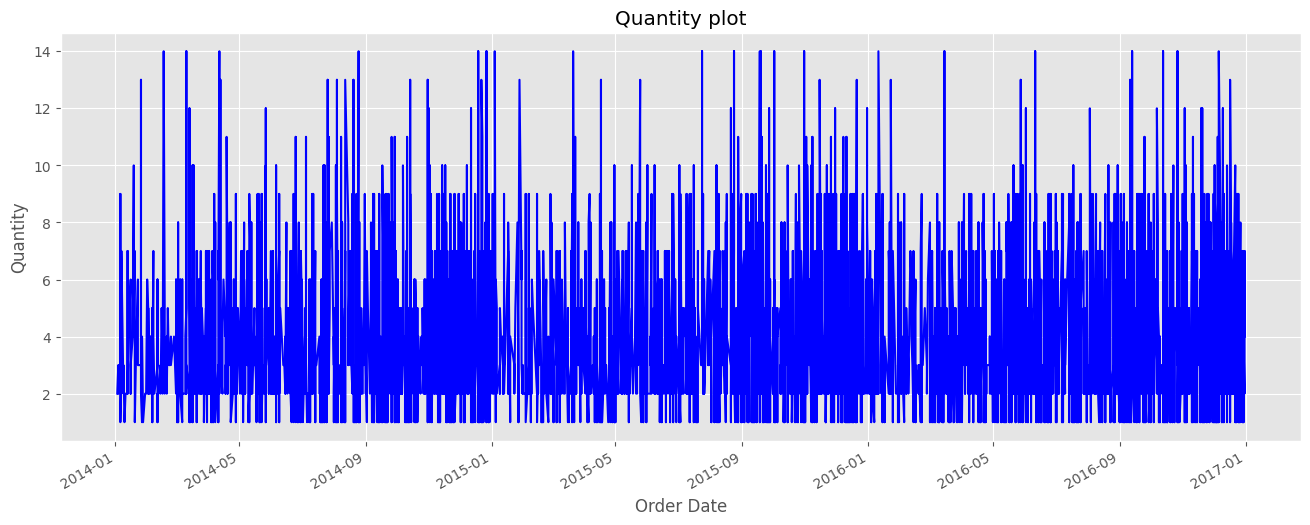

In [9]:
#Plot the time series 
# Use the ggplot style
plt.style.use('ggplot')
ax2 = train['Quantity'].plot(figsize=(16,6),color='blue')
# Set the title
ax2.set_title('Quantity plot');
# Specify the x-axis label 
ax2.set_xlabel('Order Date')
# Specify the y-axis label 
ax2.set_ylabel('Quantity')
plt.show()

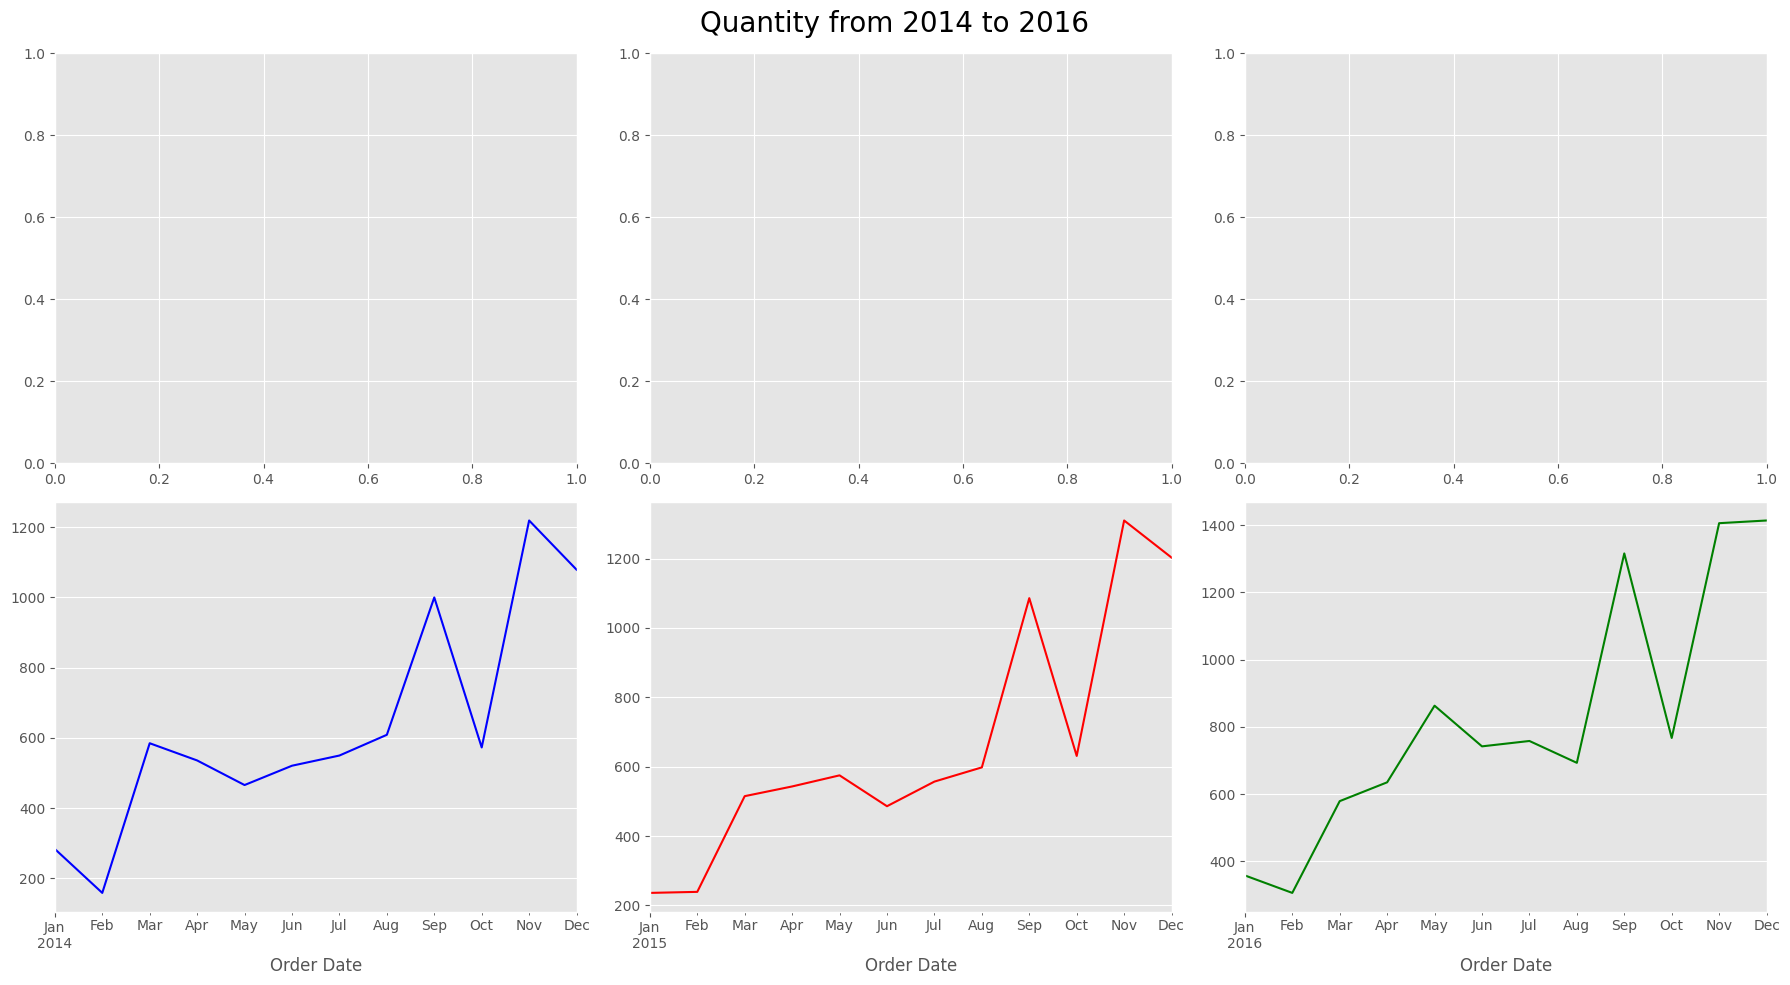

In [10]:
#creates an image containing a grid of sub-axis with 2 rows and 3 columns, and the image size is (18, 10).
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))


#Plot a graph of total sales in column 'Quantity' for 20142015,2016
train.loc['2014','Quantity'].resample('M').sum().plot( ax=ax[1,0],color='blue')
train.loc['2015','Quantity'].resample('M').sum().plot( ax=ax[1,1],color='red')
train.loc['2016','Quantity'].resample('M').sum().plot( ax=ax[1,2],color='green')
#title 
plt.suptitle('Quantity from 2014 to 2016',fontsize=20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.92, 
                    wspace=0.4, 
                    hspace=0.4)

fig.tight_layout()
plt.show()

#### Visualisation of monthly sold products <a id="month"></a>

In [11]:
#extract month information and convert data type
df_train['month'] = df_train['Order Date'].dt.to_period('M')
df_train['month'] = df_train['month'].astype(str)
dff2=df_train.copy()
df_train['month'] = pd.to_datetime(df_train['month'])

In [12]:
#DataFrame dff_train with index of month values, column 'Quantity_month' contains total quantity of goods sold in each month
dff_train = df_train.groupby(['month']).agg({'Quantity':'sum'})
dff_train['month'] = dff_train.index
dff_train.drop(['month'],axis=1,inplace=True)
dff_train.rename(columns = {'Quantity':'Quantity_month'}, inplace = True)

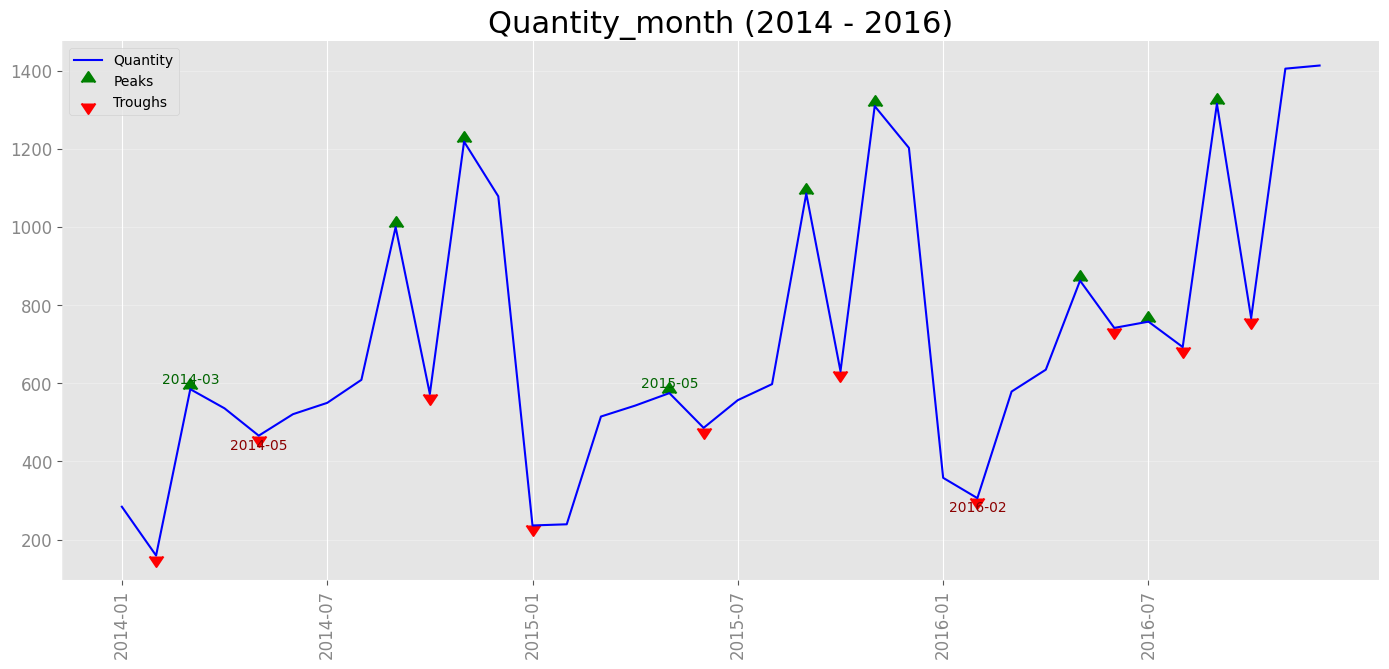

In [13]:
dff2=dff2.groupby(['month']).agg({'Quantity':'sum'})
dff2['month'] = dff2.index
dff2.rename(columns = {'Quantity':'Quantity_month'}, inplace = True)
# Get the Peaks and Troughs
data = dff2['Quantity_month'].values
doublediff = np.diff(np.sign(np.diff(data)))
peak_locations = np.where(doublediff == -2)[0] + 1

doublediff2 = np.diff(np.sign(np.diff(-1*data)))
trough_locations = np.where(doublediff2 == -2)[0] + 1

# Draw Plot
plt.figure(figsize=(17,7))
plt.plot('month', 'Quantity_month', data=dff2, color='blue', label='Quantity')
plt.scatter(dff2.month[peak_locations], dff2.Quantity_month[peak_locations], marker=mpl.markers.CARETUPBASE, color='green', s=100, label='Peaks')
plt.scatter(dff2.month[trough_locations], dff2.Quantity_month[trough_locations], marker=mpl.markers.CARETDOWNBASE, color='red', s=100, label='Troughs')

# Annotate
for t, p in zip(trough_locations[1::5], peak_locations[::3]):
    plt.text(dff2.month[p], dff2.Quantity_month[p]+15, dff2.month[p], horizontalalignment='center', color='darkgreen')
    plt.text(dff2.month[t], dff2.Quantity_month[t]-35, dff2.month[t], horizontalalignment='center', color='darkred')
# Decoration
xtick_location = dff2.index.tolist()[::6]
xtick_labels = dff2.month.tolist()[::6]
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=90, fontsize=12, alpha=.7)
plt.title("Quantity_month (2014 - 2016)", fontsize=22)
plt.yticks(fontsize=12, alpha=.7)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper left')
plt.grid(axis='y', alpha=.3)
plt.show()

#### Seasonality, Trend and Noise <a id="trend"></a>

In [14]:
decomposition=seasonal_decompose(dff_train, model = 'additive')
# Extract the trend and seasonal components
trend = decomposition.trend
seasonal = decomposition.seasonal
sales_decomposed = pd.DataFrame(np.c_[trend, seasonal], index=dff_train.index, columns=['trend', 'seasonal'])

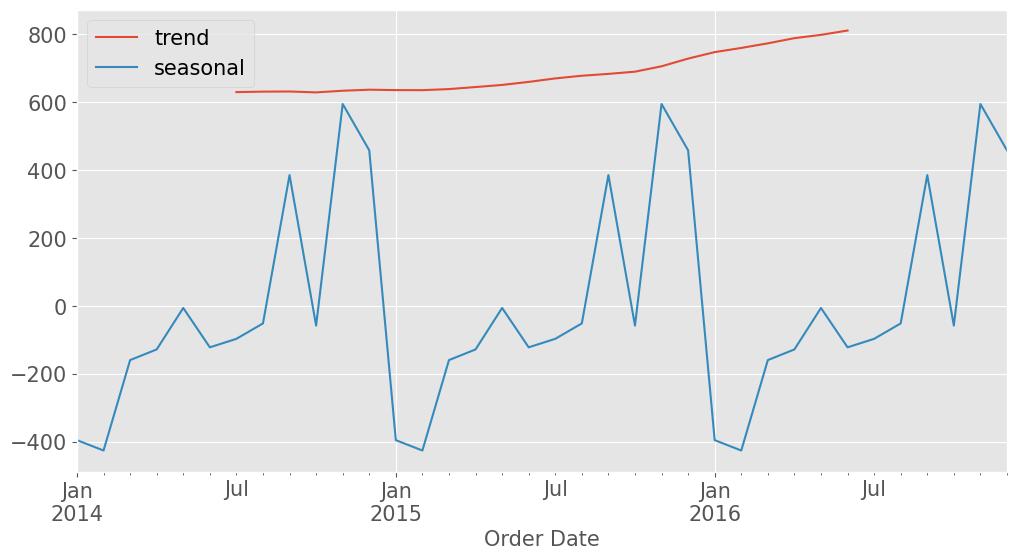

In [15]:
# Plot the values of the sales_decomposed DataFrame
ax = sales_decomposed.plot(figsize=(12, 6), fontsize=15)

# Specify axis labels
ax.set_xlabel('Order Date', fontsize=15)
plt.legend(fontsize=15)
plt.show()

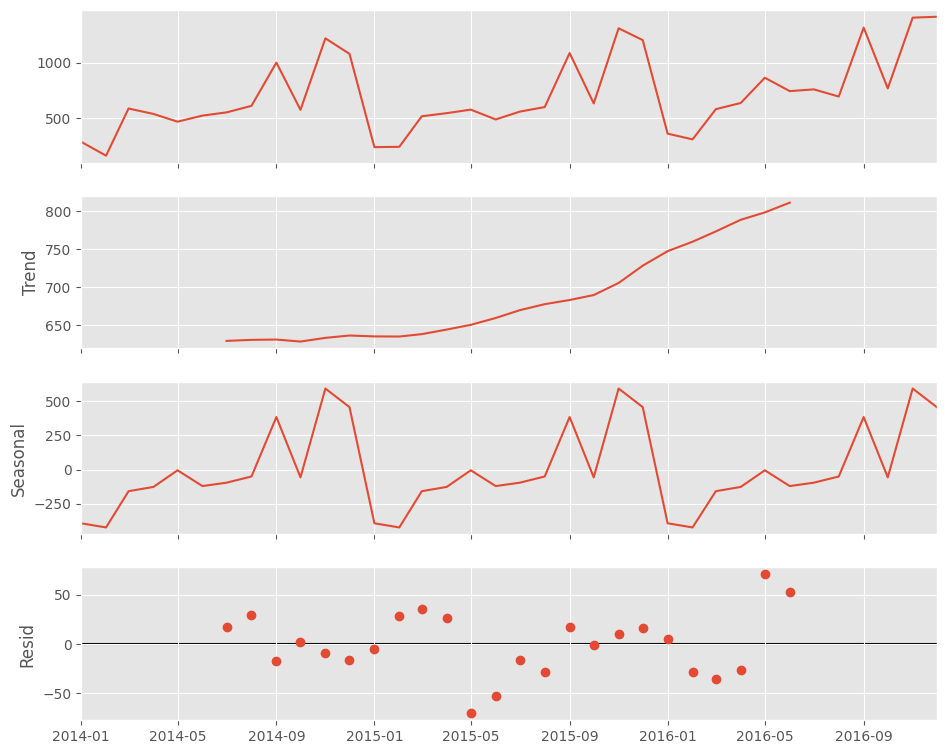

In [16]:
# seasonal_decompose for additive model
seasonal_decompose(dff_train, model = 'additive').plot().set_size_inches(10, 8)

### Future Sales Forecasting with SARIMA model <a id="future"></a>
#### Checks for Stationarity of the time serie <a id="stationarity"></a>

There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary. Here, i will use Augmented Dickey Fuller test.The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [17]:
result = adfuller(dff_train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.490466
p-value: 0.008235
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613


The p-value is less than the critical value of 0.05. Therefore, we can confirm that the chain is currently at rest. We can say that D=0.

#### Autocorrelation in time series data <a id="Autocorrelation"></a>
In order to figure out the parameters p,d,q,P,D,Q of SARIMA model we would need to plot the ACF and PACF plots.
ACF stands for Auto Correlation Function and PACF stands for Partial Auto Correlation Function.

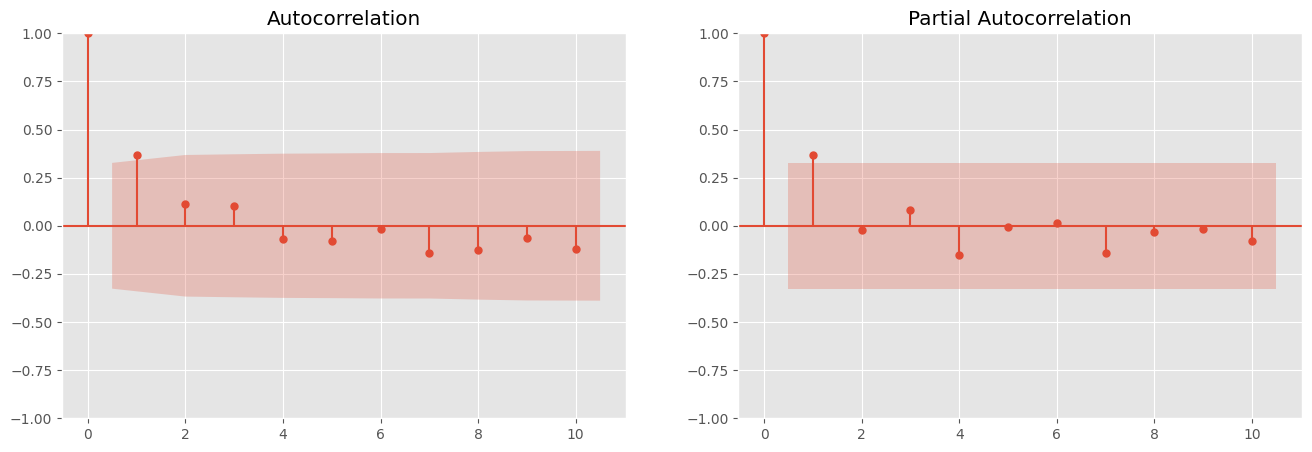

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
plot_acf(dff_train,lags=10, ax=axes[0])
plot_pacf(dff_train,lags=10, ax=axes[1])
plt.show()

#### Parameters estimation & model building <a id="build"></a>

In [19]:
#use auto_arima function from pmdarima library to find the best SARIMA model for dff_train data series.
model=auto_arima(dff_train, start_p = 0, start_q = 0,D=0, m = 12, seasonal = True, test = "adf",  trace = True, alpha = 0.05, information_criterion = 'aic', suppress_warnings = True, 
                    stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=457.030, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=516.084, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=514.359, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=458.904, Time=0.25 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=453.892, Time=0.15 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(

C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,0)(2,0,2)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\vudin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "C:\U

 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=452.115, Time=0.21 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=512.707, Time=0.02 sec
 ARIMA(2,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.32 sec


C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(2,1,0)(2,0,2)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\vudin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "C:\U

 ARIMA(2,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=450.341, Time=0.23 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=452.980, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=448.801, Time=0.26 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=448.157, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=448.792, Tim

C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,1)(1,0,0)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\vudin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "C:\U

 ARIMA(1,1,0)(1,0,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,2)(1,0,0)[12]             : AIC=inf, Time=nan sec

Best model:  ARIMA(0,1,1)(1,0,0)[12]          
Total fit time: 12.564 seconds


C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,1,2)(1,0,0)[12]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "C:\Users\vudin\anaconda3\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "C:\Users\vudin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = super(MLEModel, self).fit(start_params, method=method,
  File "C:\U

According to the algorithm the best SARIMA model is SARIMA(0,1,1)(1,0,0)[12]

In [20]:
#display summary information about the model SARIMA
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -220.106
Date:                             Sat, 15 Jul 2023   AIC                            446.213
Time:                                     15:12:04   BIC                            450.879
Sample:                                 01-01-2014   HQIC                           447.824
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6790      0.117     -5.782      0.000      -0.909      -0.449
ar.S.L12       0.9750      0.014     70.063      0.000       0.948       1.002
sigma2      5825.7267   1630.389      3.573      0.000    2630.223    9021.230
===================================================================================
Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.36   Prob(JB):                         0.56
Heteroskedasticity (H):               1.12   Skew:                            -0.27
Prob(H) (two-sided):                  0.85   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<p>According to the model summary:
Because the p-value of the Ljung-Box test is greater than 0.05, we cannot reject the null hypothesis that the residuals are independent.
Because the p-value of the heteroskedasticity test is grater than 0.05, we fail to reject the null hypothesis the null hypothesis of Homoscedasticity.
Because the p-value of the Jarque Bera test is grater than 0.05, we fail to reject the null hypothesis and conclude that the sample data follows normal distribution.
We conclude that residuals form a white noise, so the the model is good and can be used for prediction.</p>

#### Diagnostics of residuals <a id="diagnostics"></a>

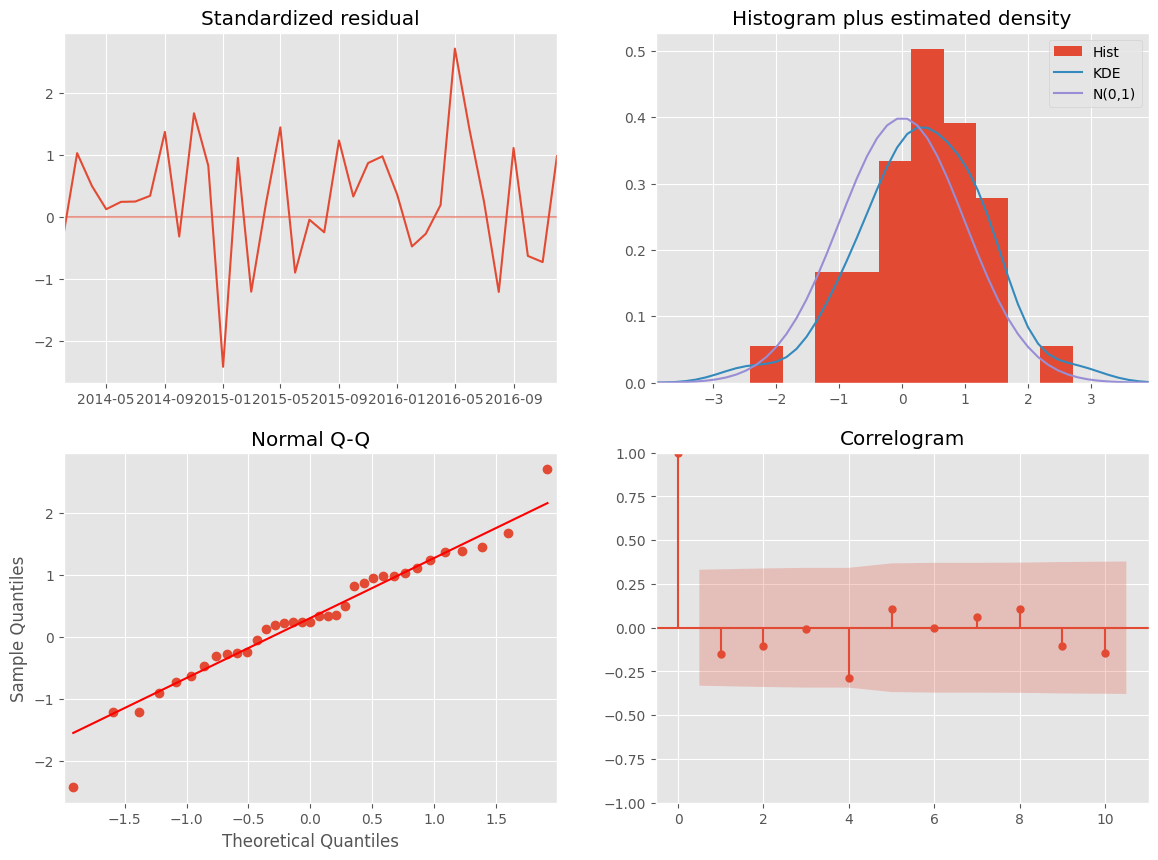

In [21]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

#### Forecasting <a id="forecast"></a>

In [22]:
#value prediction for the next 12 months
prediction, confint = model.predict(n_periods = 12, return_conf_int = True) #95% CI default
start = dff_train.index[-1] + pd.DateOffset(months=1)
period_index = pd.period_range(start=start, periods=12, freq='M')
period_index = period_index.to_timestamp()
prediction

2017-01-01     539.503890
2017-02-01     488.806116
2017-03-01     754.969432
2017-04-01     809.567035
2017-05-01    1031.857277
2017-06-01     913.887456
2017-07-01     929.486771
2017-08-01     866.114553
2017-09-01    1473.512889
2017-10-01     938.261386
2017-11-01    1561.259037
2017-12-01    1569.058695
Freq: MS, dtype: float64

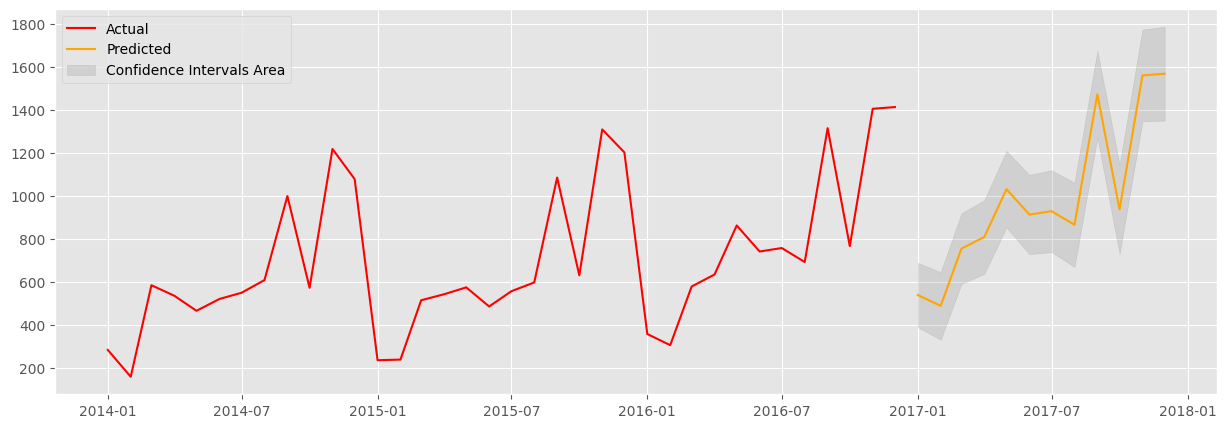

In [33]:
#draw a comparison chart between actual data and predicted value
cf= pd.DataFrame(confint)

prediction_series = pd.Series(prediction,index=period_index)
plt.figure(figsize=(15, 5))
plt.plot(dff_train, color='red', label='Actual')
plt.plot(prediction_series, color='orange', label='Predicted')

plt.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.2, label='Confidence Intervals Area')
plt.legend()
plt.show()

#### Model evaluation <a id="evaluation"></a>

#### Visualisation of monthly sold products <a id="test-month"></a>

In [24]:
test['Order Date'] = test['Order Date'].apply(lambda x:datetime.datetime.strptime(x, '%m/%d/%Y'))
#save a copy of sales_train
df_test=test.copy()
# Set the date column as the index of DataFrame 
test=test.set_index('Order Date')

In [25]:
df_test['month'] = df_test['Order Date'].dt.to_period('M')
df_test['month'] = df_test['month'].astype(str)
dff2=df_test.copy()
df_test['month'] = pd.to_datetime(df_test['month'])

In [26]:
#DataFrame dff_train with index of month values, column 'Quantity_month' contains total quantity of goods sold in each month
dff_test = df_test.groupby(['month']).agg({'Quantity':'sum'})
dff_test['month'] = dff_test.index
dff_test.drop(['month'],axis=1,inplace=True)
dff_test.rename(columns = {'Quantity':'Quantity_month'}, inplace = True)

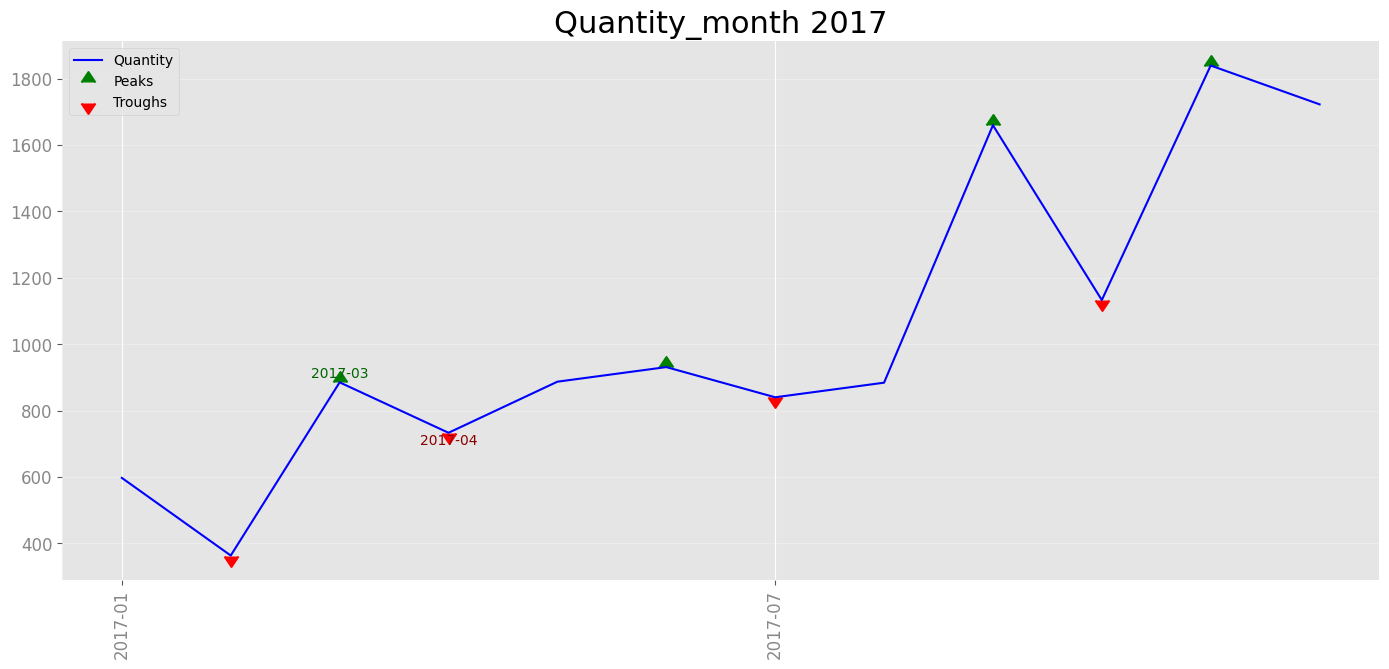

In [27]:
#The graph above shows the movement of commodities in 2017, along with notable highs and lows.
dff2=dff2.groupby(['month']).agg({'Quantity':'sum'})
dff2['month'] = dff2.index
dff2.rename(columns = {'Quantity':'Quantity_month'}, inplace = True)
# Get the Peaks and Troughs
data = dff2['Quantity_month'].values
doublediff = np.diff(np.sign(np.diff(data)))
peak_locations = np.where(doublediff == -2)[0] + 1

doublediff2 = np.diff(np.sign(np.diff(-1*data)))
trough_locations = np.where(doublediff2 == -2)[0] + 1

# Draw Plot
plt.figure(figsize=(17,7))
plt.plot('month', 'Quantity_month', data=dff2, color='blue', label='Quantity')
plt.scatter(dff2.month[peak_locations], dff2.Quantity_month[peak_locations], marker=mpl.markers.CARETUPBASE, color='green', s=100, label='Peaks')
plt.scatter(dff2.month[trough_locations], dff2.Quantity_month[trough_locations], marker=mpl.markers.CARETDOWNBASE, color='red', s=100, label='Troughs')
# Annotate
for t, p in zip(trough_locations[1::5], peak_locations[::3]):
    plt.text(dff2.month[p], dff2.Quantity_month[p]+15, dff2.month[p], horizontalalignment='center', color='darkgreen')
    plt.text(dff2.month[t], dff2.Quantity_month[t]-35, dff2.month[t], horizontalalignment='center', color='darkred')
# Decoration
xtick_location = dff2.index.tolist()[::6]
xtick_labels = dff2.month.tolist()[::6]
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=90, fontsize=12, alpha=.7)
plt.title("Quantity_month 2017", fontsize=22)
plt.yticks(fontsize=12, alpha=.7)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper left')
plt.grid(axis='y', alpha=.3)
plt.show()

In [28]:
#Group data by month and calculate the total quantity of goods ('Quantity') for each month.
dff_test

,Quantity_month
month,
2017-01-01,597
2017-02-01,363
2017-03-01,885
2017-04-01,733
2017-05-01,887
2017-06-01,931
2017-07-01,840
2017-08-01,884
2017-09-01,1660


In [30]:
from sklearn.metrics import mean_squared_error

# Giá trị thực tế
actual_values = dff_test # Dữ liệu thực tế của 12 quan sát tiếp theo

# Giá trị dự đoán từ mô hình SARIMA
predicted_values = prediction

# Tính giá trị RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

print("RMSE:", rmse)


RMSE: 143.06254524937938


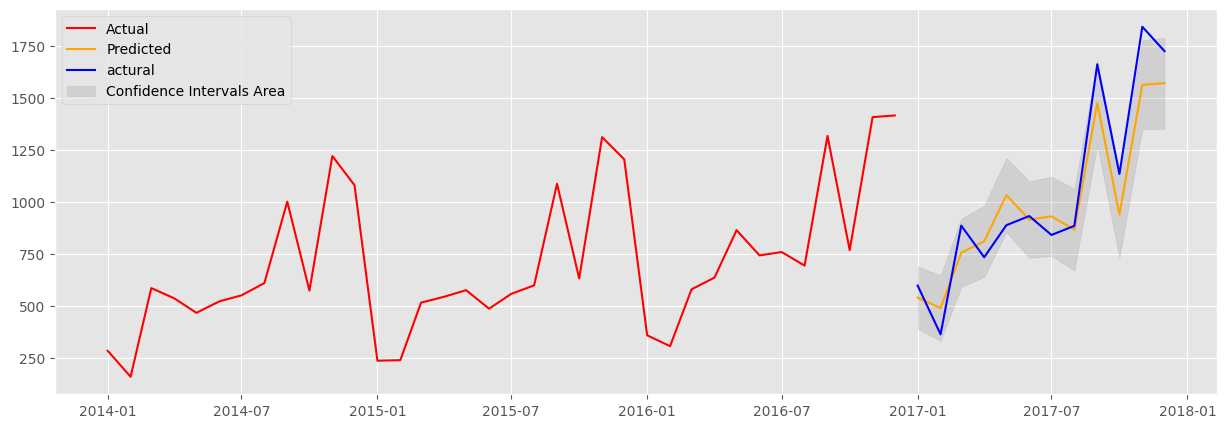

In [35]:
#draw a comparison chart between actual data and predicted value
cf= pd.DataFrame(confint)

prediction_series = pd.Series(prediction,index=period_index)
plt.figure(figsize=(15, 5))
plt.plot(dff_train, color='red', label='Actual')
plt.plot(prediction_series, color='orange', label='Predicted')
plt.plot(dff_test, color='blue', label='actural')
plt.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.2, label='Confidence Intervals Area')
plt.legend()
plt.show()